# Proceso de distincion de ventas x materiales

### Librerias

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os 

import const
from utils import mask_float
from random import randint

import scipy as sp
import statsmodels.api as sm 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score

### Funciones

In [144]:
def remove_outlier(df_in, col_name):
    
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

### Preprocesamiento

In [3]:
header_names = ["oficinas", "clientes", "agentes", "segmentos", "ventas", "materiales"]

converters = {
    "oficinas": str,
    "clientes": str,
    "agentes": str,
    "segmentos": str,
    "ventas": mask_float,
    "materiales": mask_float
}

data = pd.read_csv(os.path.join(const.ROOT_DIR, "files/bases/base.csv"), 
    sep = ";", 
    skiprows = 1,
    usecols = [0, 1, 2, 4, 5, 6], 
    names = header_names, 
    converters = converters
    )

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15455 entries, 0 to 15454
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   oficinas    15455 non-null  object 
 1   clientes    15455 non-null  object 
 2   agentes     15455 non-null  object 
 3   segmentos   15455 non-null  object 
 4   ventas      15455 non-null  float64
 5   materiales  15455 non-null  float64
dtypes: float64(2), object(4)
memory usage: 724.6+ KB


In [4]:
#replace agentes for ("Directa" or "Indirecta")
mask_indirecta = data["agentes"].str.contains("#")
data.loc[mask_indirecta, "agentes"] = "Directa"
data.loc[~mask_indirecta, "agentes"] = "Indirecta"

#delete 0'ros inside "Ventas" or "materiales"
mask_zero = (data["ventas"] <= 0) & (data["materiales"] == 0)
data.drop(data[mask_zero].index, inplace=True)
data.head()

,oficinas,clientes,agentes,segmentos,ventas,materiales
0,R Bogota Norte,10005806,Directa,Mayorista Snackero,3769314.0,45.0
1,R Bogota Norte,10005806,Directa,Mayorista Snackero,6746115.0,40.0
2,R Bogota Norte,10005806,Directa,Mayorista Snackero,9655944.0,59.0
3,R Bogota Norte,10005806,Directa,Mayorista Snackero,5245732.0,32.0
4,R Bogota Norte,10005806,Directa,Mayorista Snackero,10195569.0,56.0


In [5]:
#group all
data_grouped = data.groupby(["oficinas", "clientes", "agentes", "segmentos"], as_index=False)[["ventas", "materiales"]].mean()
data_grouped.head()

,oficinas,clientes,agentes,segmentos,ventas,materiales
0,R Altillano,10037570,Directa,MY Com Rapi/Transf,3.421903e+05,4.833333
1,R Altillano,10051413,Directa,Mayorista Snackero,5.519405e+06,63.666667
2,R Altillano,10091442,Directa,Mayorista Mixto,1.005360e+07,21.833333
3,R Altillano,10091466,Directa,Mayorista Snackero,3.719446e+07,120.000000
4,R Altillano,10091469,Directa,Mayorista Mixto,8.200213e+06,37.166667


### Analisis

In [6]:
data_grouped.describe()

,ventas,materiales
count,2.871000e+03,2871.000000
mean,1.922312e+07,34.821665
std,4.367997e+07,27.307924
min,1.465000e+03,1.000000
25%,2.610477e+06,16.166667
50%,7.069192e+06,28.833333
75%,1.778397e+07,46.000000
max,7.044108e+08,243.333333


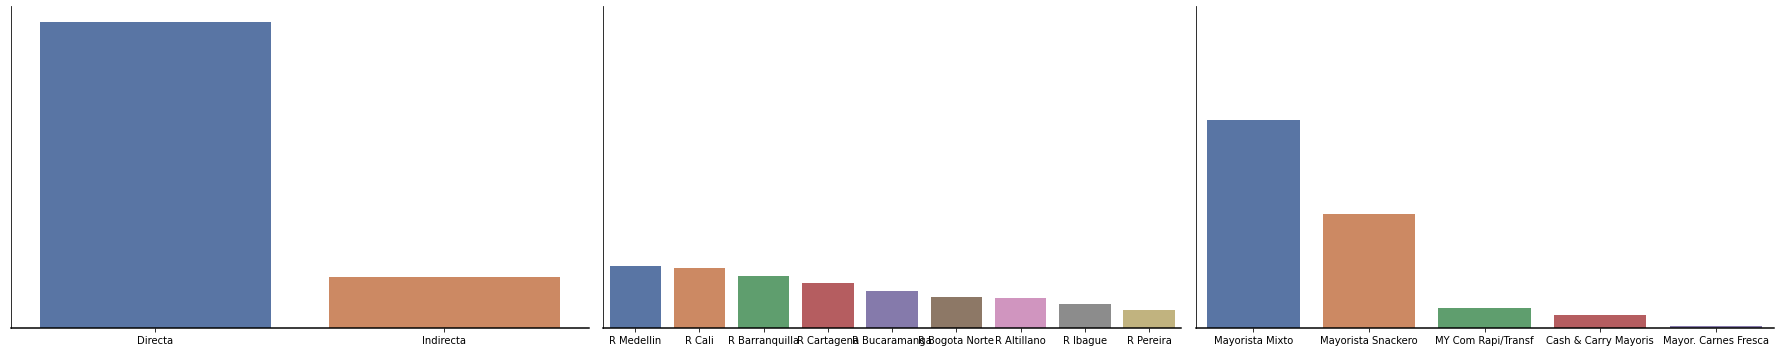

In [7]:
f, axs = plt.subplots(1, 3, figsize=(25, 5), sharey=True)

for idx, group in enumerate(["agentes", "oficinas", "segmentos"]):
    uniques = data[group].value_counts()
    sns.barplot(x=list(uniques.index), y=list(uniques.values), palette="deep", ax=axs[idx])
    axs[idx].axhline(0, color="k", clip_on=False)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

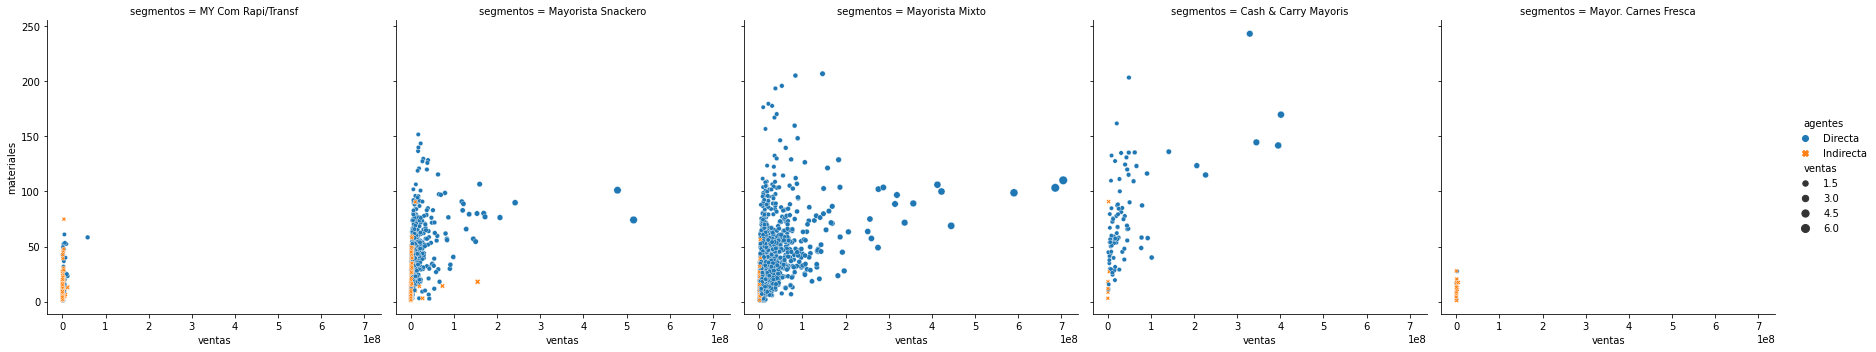

In [8]:
# Create a visualization
sns.relplot(
    data=data_grouped,
    x="ventas", y="materiales", col="segmentos",
    hue="agentes", style="agentes", size="ventas",
)

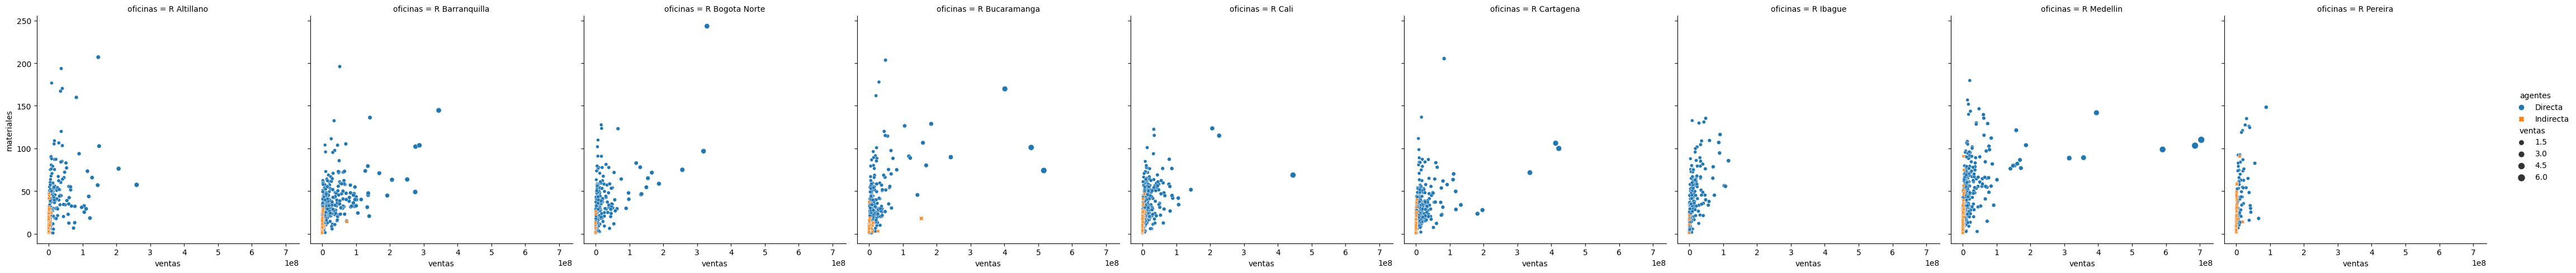

In [284]:
sns.relplot(
    data=data_grouped,
    x="ventas", y="materiales", col="oficinas",
    hue="agentes", style="agentes", size="ventas",
)

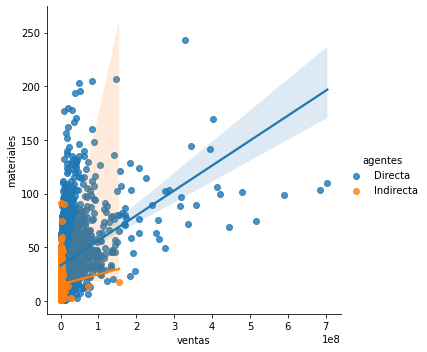

In [9]:
sns.lmplot(data=data_grouped, x="ventas", y="materiales", hue="agentes")

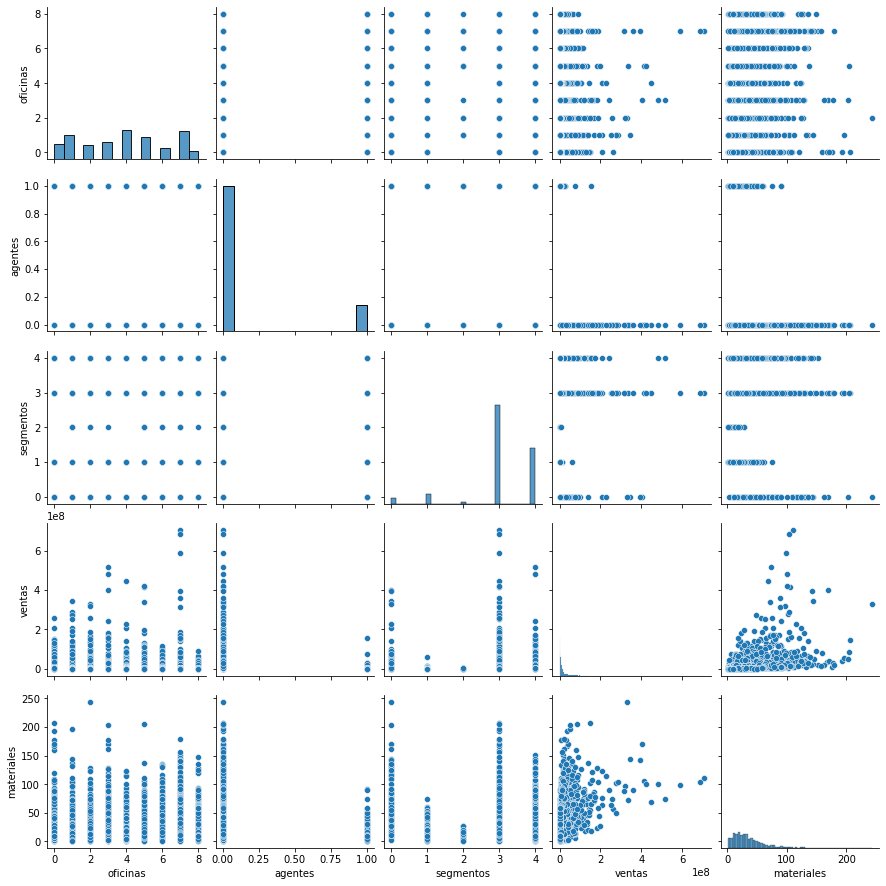

In [64]:
sns.pairplot(data_grouped)

### Transformación

In [11]:
#shuffle data
data_grouped.sample(frac=1).reset_index(drop=True)

#delete column "clientes" = id
data_grouped.drop(['clientes'], axis = 1, inplace = True) 

data_grouped.head()

,oficinas,agentes,segmentos,ventas,materiales
0,R Altillano,Directa,MY Com Rapi/Transf,3.421903e+05,4.833333
1,R Altillano,Directa,Mayorista Snackero,5.519405e+06,63.666667
2,R Altillano,Directa,Mayorista Mixto,1.005360e+07,21.833333
3,R Altillano,Directa,Mayorista Snackero,3.719446e+07,120.000000
4,R Altillano,Directa,Mayorista Mixto,8.200213e+06,37.166667


In [12]:
data_grouped.isnull().any(axis=0)

oficinas      False
agentes       False
segmentos     False
ventas        False
materiales    False
dtype: bool

In [13]:
#tranform categorical data
encoders = {
    "oficinas": LabelEncoder(),
    "segmentos": LabelEncoder(),
    "agentes": LabelBinarizer(),
}

for key in encoders.keys():
    data_grouped[key] = encoders[key].fit_transform(data_grouped[key].values)


# feature-scaling - StandardScaler
scaler = StandardScaler()
scaler.fit(data_grouped.values)
transform_data = pd.DataFrame(scaler.transform(data_grouped.values), index=data_grouped.index, columns=data_grouped.columns)
transform_data.head()

,oficinas,agentes,segmentos,ventas,materiales
0,-1.625023,-0.423149,-2.262991,-0.432331,-1.098346
1,-1.625023,-0.423149,0.968299,-0.313785,1.056471
2,-1.625023,-0.423149,-0.108798,-0.209962,-0.475708
3,-1.625023,-0.423149,0.968299,0.411504,3.119724
4,-1.625023,-0.423149,-0.108798,-0.252400,0.085888


### Categorical data

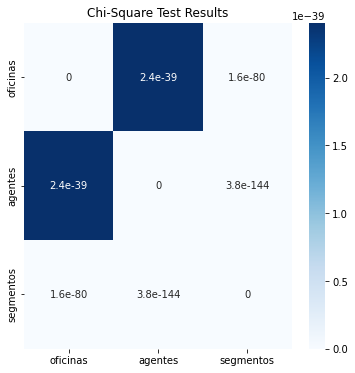

In [93]:
cat_columns = ["oficinas", "agentes", "segmentos"]
df = data_grouped.copy()

resultant = pd.DataFrame(data=[(0 for i in range(len(cat_columns))) for i in range(len(cat_columns))], 
                         columns=cat_columns, index = cat_columns)

for i in cat_columns:
    for j in cat_columns:
        if i != j:
            _, p, *_ = sp.stats.chi2_contingency(pd.crosstab(df[i], df[j]))
            resultant.loc[i,j] = p

fig = plt.figure(figsize=(6,6))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

Observaciones:

- Ninguna variable categorica presenta independencia en el umbral de P-value > 0.05

<AxesSubplot:>

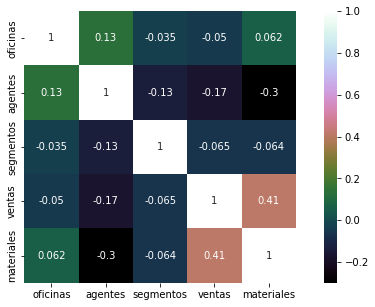

In [94]:
corr_mat = data_grouped.corr(method='pearson')
plt.figure(figsize=(10,5))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

Observaciones:

- las variables ventas - materiales presentan cierta correlacion positiva representativa
- las variables agentes - materiales presentan cierta correlacion negativa
- el resto de variables presentan correlacion negativa no tan fuerte

In [70]:
exog_with_const = sm.add_constant(data_grouped[['oficinas', 'agentes', 'segmentos', 'ventas']])
model = sm.OLS(data_grouped['materiales'], exog_with_const)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             materiales   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     226.7
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          3.00e-169
Time:                        10:58:09   Log-Likelihood:                -13174.
No. Observations:                2871   AIC:                         2.636e+04
Df Residuals:                    2866   BIC:                         2.639e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.9208      1.801     19.390      0.000      31.390      38.452
oficinas       1.2626      0.186      6.790      0.000       0.898       1.627
agentes      -19.8434      1.279    -15.513      0.000     -22.352     -17.335
segmentos     -2.0811      0.485     -4.289      0.000      -3.032      -1.130
ventas      2.299e-07   1.04e-08     22.161      0.000     2.1e-07     2.5e-07
==============================================================================
Omnibus:                     1148.583   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6756.258
Skew:                           1.800   Prob(JB):                         0.00
Kurtosis:                       9.597   Cond. No.                     2.02e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observaciones:

- R2 es un valor muy bajo indicando alta varianza entre variables
- Ninguna variable supera el umbral de p > 0.05  por ende la H_nula se rechaza (variables poseen correlacion con la variable dependiente)

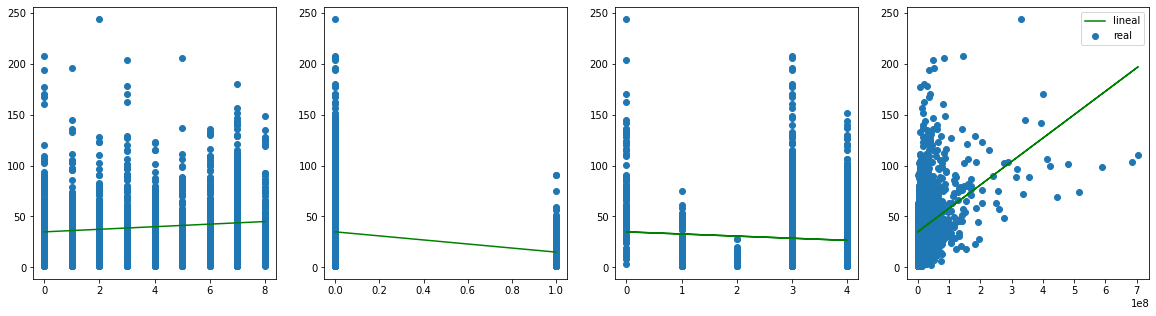

In [38]:
use_cols = ['oficinas', 'agentes', 'segmentos', 'ventas']
fig, axs = plt.subplots(1, len(use_cols), figsize=(20,5))

for idx, col in enumerate(use_cols):
    # axs[idx].plot(transform_data[col], res.predict(exog_with_const), label='estimate', color="red")
    axs[idx].plot(data_grouped[col], np.poly1d([res.params[col], res.params["const"]])(data_grouped[col]), label='lineal', color="green")
    axs[idx].scatter(data_grouped[col], data_grouped['materiales'], label='real')

plt.legend()

In [101]:
fincs = {'predictor': [], 'r-squared':[], 'p_value_pass':[]}

for idx, col in enumerate(use_cols):
    temp_model = sm.OLS(data_grouped['materiales'], sm.add_constant(data_grouped[col])).fit()
    y_preds = temp_model.predict(sm.add_constant(data_grouped[col]))
    fincs['predictor'].append(col)
    fincs['r-squared'].append(r2_score(data_grouped['materiales'], y_preds))
    fincs['p_value_pass'].append([(p < 0.05) for p in temp_model.pvalues.values])

function_df = pd.DataFrame(fincs).sort_values(by=['r-squared'], ascending = False)
function_df.head()

,predictor,r-squared,p_value_pass
3,ventas,0.168535,"[True, True]"
1,agentes,0.089300,"[True, True]"
2,segmentos,0.004067,"[True, True]"
0,oficinas,0.003857,"[True, True]"


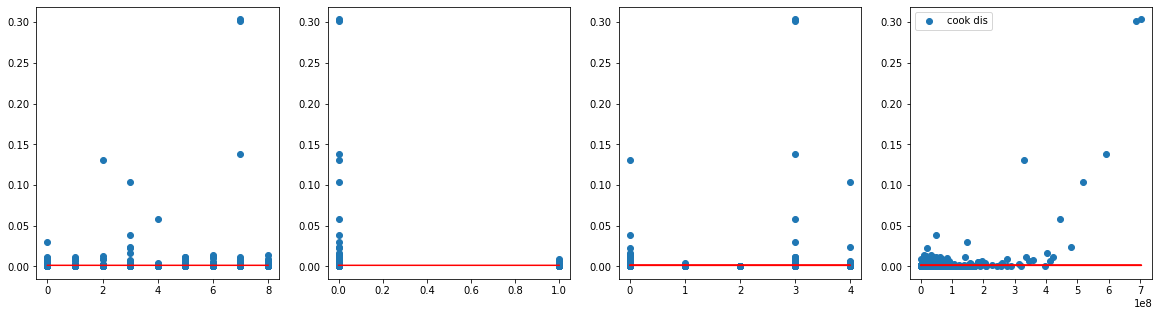

In [56]:
influence = res.get_influence()
c_distance = influence.cooks_distance

fig, axs = plt.subplots(1, len(use_cols), figsize=(20,5))

for idx, col in enumerate(use_cols):
    axs[idx].scatter(data_grouped[col], c_distance[0], label='cook dis')
    axs[idx].plot(data_grouped[col], np.repeat(4/len(data_grouped[col]), len(data_grouped[col])), color = "r")
plt.legend()

In [72]:
mask_outliers = c_distance[0] <= 4 / data_grouped.shape[0]
without_outliers = data_grouped[mask_outliers]

exog_with_const = sm.add_constant(without_outliers[['oficinas', 'agentes', 'segmentos', 'ventas']])
model = sm.OLS(without_outliers['materiales'], exog_with_const)
res2 = model.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             materiales   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     261.7
Date:                Fri, 05 Aug 2022   Prob (F-statistic):          1.25e-190
Time:                        10:59:11   Log-Likelihood:                -11810.
No. Observations:                2743   AIC:                         2.363e+04
Df Residuals:                    2738   BIC:                         2.366e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9398      1.510     13.204      0.000      16.979      22.901
oficinas       1.3360      0.145      9.192      0.000       1.051       1.621
agentes      -15.7428      0.992    -15.867      0.000     -17.688     -13.797
segmentos      1.2837      0.405      3.169      0.002       0.489       2.078
ventas       3.02e-07    1.3e-08     23.190      0.000    2.76e-07    3.28e-07
==============================================================================
Omnibus:                      343.996   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.985
Skew:                           0.912   Prob(JB):                    1.10e-111
Kurtosis:                       4.068   Cond. No.                     1.44e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

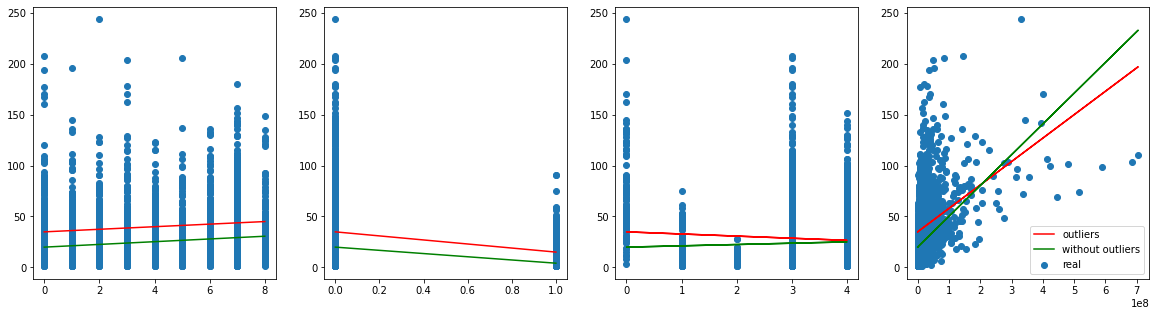

In [61]:
use_cols = ['oficinas', 'agentes', 'segmentos', 'ventas']
fig, axs = plt.subplots(1, len(use_cols), figsize=(20,5))

for idx, col in enumerate(use_cols):
    axs[idx].plot(data_grouped[col], np.poly1d([res.params[col], res.params["const"]])(data_grouped[col]), label='outliers', color="red")
    axs[idx].plot(data_grouped[col], np.poly1d([res2.params[col], res2.params["const"]])(data_grouped[col]), label='without outliers', color="green")
    axs[idx].scatter(data_grouped[col], data_grouped['materiales'], label='real')

plt.legend()

### Entrenamiento y validación

<AxesSubplot:>

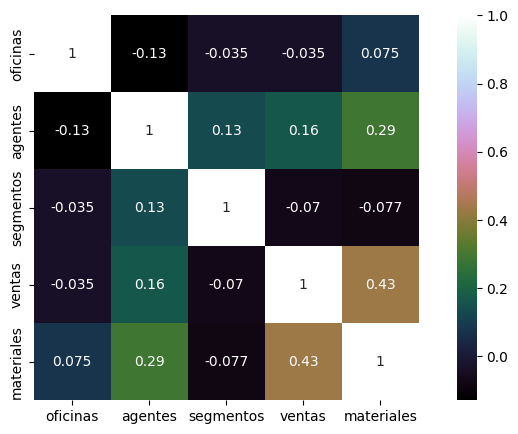

In [157]:
corr_mat = transform_data.corr(method='pearson')
plt.figure(figsize=(10,5))
sns.heatmap(corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

In [268]:
x_temp = transform_data.values[:, :-1]
y = transform_data.values[:, -1]

#transform to polynomial function
func_poly = PolynomialFeatures(degree=2, include_bias=False)
x = func_poly.fit_transform(x_temp)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.3, random_state = 42)

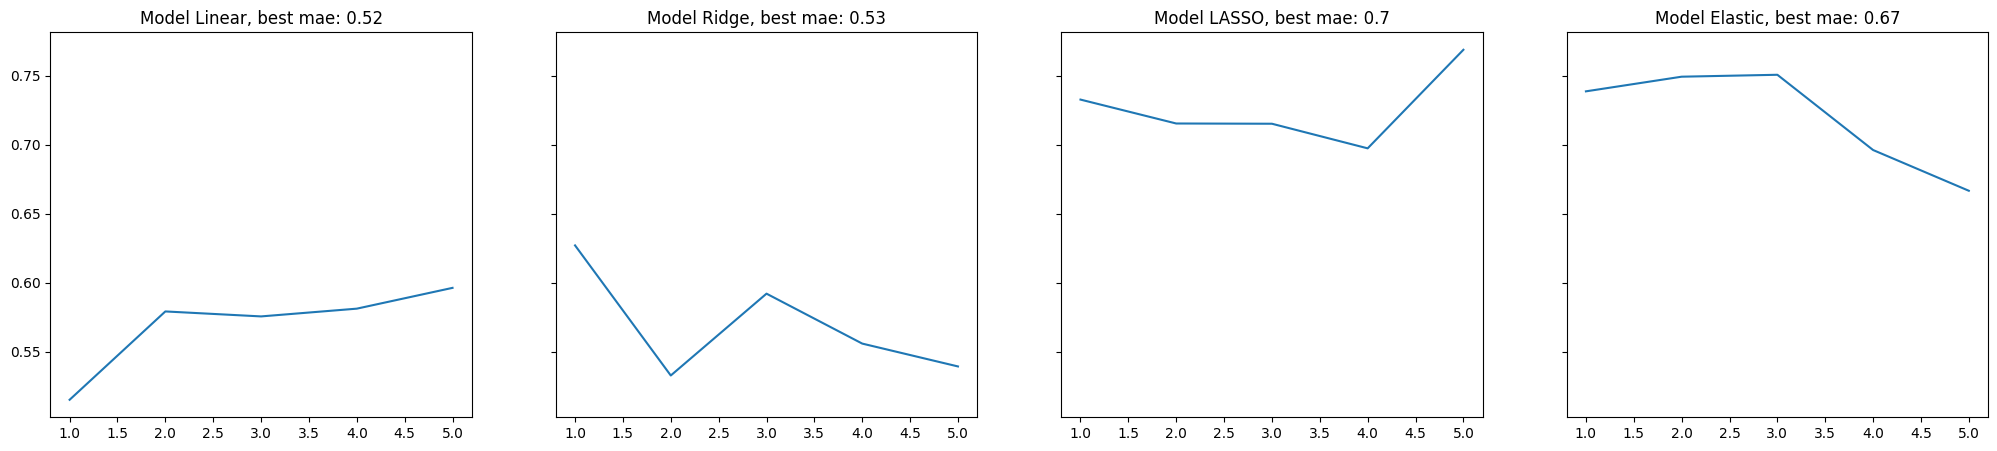

In [269]:
from sklearn.feature_selection import RFE

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "LASSO": Lasso(),
    "Elastic": ElasticNet()
}

maes = {
    key: None for key in models.keys()
}

best_folds = {
    **maes
}

f, axs = plt.subplots(1, len(models), sharey='all', figsize=(25,5))

for idx, (key, model) in enumerate(models.items()):

    kfolds = model_selection.KFold(n_splits=5, random_state = randint(1, 10), shuffle=True).split(x_train, y_train) #iterable (only use train sub group)

    best_fold = None
    best_mae = 1
    _maes = []

    for idx_train, idx_test in kfolds:
        
        model.fit(x_train[idx_train], y_train[idx_train])
        mae = mean_absolute_error(y_train[idx_test], model.predict(x_train[idx_test]))
        _maes.append(mae)

        if np.abs(mae) < np.abs(best_mae):
            best_mae = mae
            best_fold = (idx_train, idx_test) #save only index
    
    #save the best sub fold use for train and the mean MAE result
    best_folds[key] = best_fold
    maes[key] = np.abs(_maes).mean()

    #plot actual mean MAE
    axs[idx].plot(list(range(1, len(_maes) + 1)), np.abs(_maes))
    axs[idx].set_title(f"Model {key}, best mae: {round(best_mae, 2)}")

In [251]:
#train models with the best subfold
for key in models.keys():
    idx_train, _ = best_folds[key]
    models[key].fit(x_train[idx_train], y_train[idx_train])

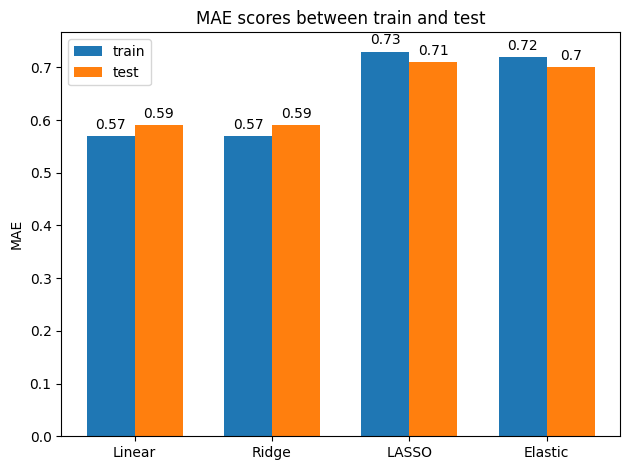

In [270]:
fig, axs = plt.subplots()

x_label = np.arange(len(maes))
width = 0.35  # the width of the bars

maes_results = []

for key_model in maes.keys():
    maes_results.append([
        round(maes[key_model], 2),
        round(mean_absolute_error(y_test, models[key_model].predict(x_test)), 2)
    ])

axs.set_ylabel('MAE')
axs.set_title('MAE scores between train and test')
axs.set_xticks(x_label, maes.keys())

rects1 = axs.bar(x_label - width/2, np.array(maes_results)[:, 0].tolist(), width, label='train')
rects2 = axs.bar(x_label + width/2, np.array(maes_results)[:, 1].tolist(), width, label='test')
axs.bar_label(rects1, padding=3)
axs.bar_label(rects2, padding=3)

axs.legend()
fig.tight_layout()

plt.show()

MAE: 0.5940061991567461


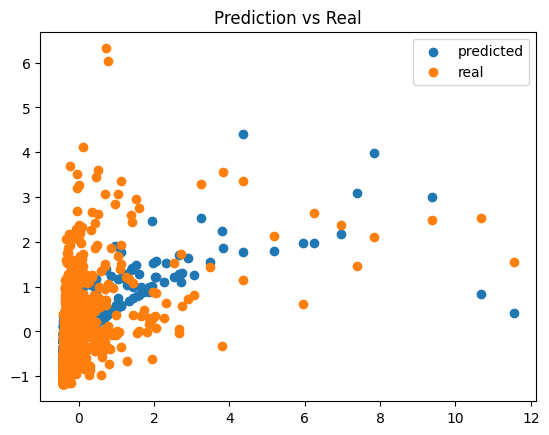

In [271]:
from sklearn.metrics import accuracy_score

prediction = models['Linear'].predict(x_test)

print(f"MAE: {mean_absolute_error(prediction, y_test)}")

plt.title('Prediction vs Real')
plt.scatter(x_test[:, 3], prediction, label='predicted')
plt.scatter(x_test[:, 3], y_test, label='real')
plt.legend()
plt.show()

In [275]:
precision = np.mean(np.abs(y_test - prediction))
precision

0.5940061991567461

In [272]:
model.coef_

array([ 0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.01422941, -0.        ,
        0.        ,  0.        , -0.        ,  0.0161017 ])

PCA y Kfold

>1 -0.726 (0.033)
>2 -0.727 (0.043)


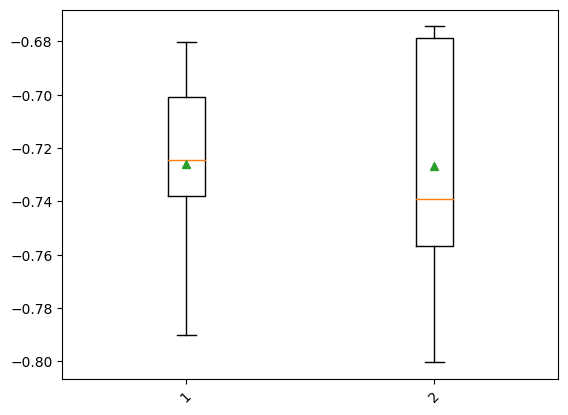

In [205]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


def get_models():
	models = dict()
	for i in range(1, transform_data.shape[1]-2):
		steps = [('pca', PCA(n_components = i)), ('m', LinearRegression())]
		models[str(i)] = Pipeline(steps=steps)
	return models

def evaluate_model(model, x, y):
	cv = model_selection.KFold(n_splits=10, shuffle=True)
	scores = model_selection.cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs= -1)
	return scores

x, y = transform_data.values[:, :-2], transform_data.values[:, -1]
models = get_models()
results, names = [], []

for name, model in models.items():
	scores = evaluate_model(model, x, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [132]:
np.arange(1, len(maes)+1)

array([1, 2, 3, 4])

In [127]:
x_label

[0, 1, 2, 3]

In [126]:
x_label - len(x_label)/2

TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [125]:
len(x_label)/2

2.0

In [124]:
width

0.35

In [122]:
np.array(real_results)[:, 0].tolist()

[0.6237493299721538,
 0.6222663789636129,
 0.7375121806642081,
 0.7379251577592434]

4